In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import pandas as pd
import sys
sys.path.append('/home/yat-lok/workspace/tvbtools/')
from tools.signaltools import SignalToolkit
import ipywidgets as widgets
my_layout = widgets.Layout()
import typing
from typing import List
import seaborn as sns

In [ ]:
# read data
filename = '/mnt/d/data/LFP/SNC/2820A/2820A_0.014.csv'
df = pd.read_csv(filename)
df_left = df.iloc[1024:,5]
df_right = df.iloc[1024:,6]
df_right_low = SignalToolkit.hamming_filter(df_right, Wn=[2,2.1], fNQ=81920/2, n=256)
df_right_high = SignalToolkit.hamming_filter(df_right, Wn=[60,100], fNQ=81920/2, n=2048)
df_left_low = SignalToolkit.hamming_filter(df_left, Wn=[2,2.1], fNQ=81920/2, n=256)
df_left_high = SignalToolkit.hamming_filter(df_left, Wn=[60,100], fNQ=81920/2, n=2048)
# visualize results
fig = plt.figure()
axes = fig.add_subplot(211)
axes.plot(df_left)
axes.plot(df_right)
plt.show()


In [ ]:
%matplotlib widget
# hilbert transform
# step 1, get the amplitude envelop of high freq
h1=signal.hilbert(df_left_high)
amplitude_envelope = np.abs(h1)

# step 2, get the phase information of low freq
l1 = signal.hilbert(df_left_low)
phase_y1=np.angle(l1)

# step 3 bin the phase
cycle = len(l1)/360
stamp = range(int(cycle))
phase_amp = []
for i in stamp:
    amp_value = np.mean(amplitude_envelope[i*360:(i+1)*360])
    phase_amp.append(amp_value)
# step 4, entropy method H
p_j = [p_j_single/np.sum(phase_amp) for p_j_single in phase_amp]
cap_H = -np.sum(p_j * np.log(p_j))

# step 5, calculate the MI
MI = (np.log(len(stamp))-cap_H) / np.log(len(stamp))
print(MI)

x_axes1 = [*stamp]

fig = plt.figure()
axes1 = fig.add_subplot(221)
axes1.bar(x_axes1, phase_amp)

# graph 2
axes2 = fig.add_subplot(222)
axes2.set_title("raw plot with low and high \nfrequency bands signal")
axes2.plot(df_left)
axes2.plot(df_left_low)
axes2.plot(df_left_high)

axes3 = fig.add_subplot(223)
axes3.plot(df_left_high)
axes3.plot(amplitude_envelope)

axes4 = fig.add_subplot(224)
axes4.plot(df_left_low)
axes4.plot(phase_y1, "o")
plt.show()

In [ ]:





def PAC(data, low_win, high_win, fs, n_order_low = 256, n_order_high=2048, visual=False):
    """
    Parameters:
    ---------------
        data:list or np.ndarray
            signal
        low_win:list
            start frequency, stop frequency
        high_win:list
            start frequency, stop frequency
    Returns:
    --------------
        Modulation Index (MI)
    """

    # def sign_check(data):
    #     signs = np.sign(data)
    #     places = []
    #     for ii in range(1, len(signs)):
    #         if signs[ii] != signs[ii-1]:
    #             places.append(ii)
    #     return len(places)

    # unify data format
    data = np.array(data)
    # filtering data into high frequency band and low frequency band
    low_freq = SignalToolkit.hamming_filter(data, Wn=low_win, fNQ=fs/2, n=n_order_low)
    high_freq = SignalToolkit.hamming_filter(data, Wn=high_win, fNQ=fs/2, n=n_order_high)
    # hilbert transform
    # step 1, get the amplitude envelop of high freq
    h1=signal.hilbert(high_freq)
    amplitude_envelope = np.abs(h1)
    # step 2, get the phase information of low freq
    l1 = signal.hilbert(low_freq)
    phase_y1=np.angle(l1)
    # step 3 bin the phase
    phase_bins = np.arange(-np.pi,np.pi,0.1)
    amp_mean = np.zeros(np.size(phase_bins)-1)      
    phase_mean = np.zeros(np.size(phase_bins)-1)     
    for k in range(np.size(phase_bins)-1):   
        phase_low = min(phase_bins[k], phase_bins[k+1]) 
        phase_high = max(phase_bins[k], phase_bins[k+1]) 
        tmp_amp = amplitude_envelope[np.where(np.logical_and(phase_y1>=phase_low, phase_y1<=phase_high))]
        amp_mean[k] = np.mean(tmp_amp)   
        phase_mean[k] = np.mean([phase_low, phase_high]) 
    # step 4, entropy method H
    p_j = [p_j_single/np.sum(amp_mean) for p_j_single in amp_mean]
    cap_H = -np.sum(p_j * np.log(p_j))
    # step 5, calculate the MI
    MI = (np.log(len(phase_bins))-cap_H) / np.log(len(phase_bins))
    print(f"Modulation Index = {MI}")
    if visual:
        fig = plt.figure(figsize=(7,7))
        # graph 1
        axes1 = fig.add_subplot(221)
        axes1.set_title("distribution of the mean amplitude\n in each phase bin")
        axes1.bar(phase_bins[:-1], amp_mean)
        # graph 2
        axes2 = fig.add_subplot(222)
        axes2.set_title("raw plot with low and high \nfrequency bands signal")
        axes2.plot(data)
        axes2.plot(low_freq)
        axes2.plot(high_freq)
        # graph 3
        axes3 = fig.add_subplot(223)
        axes3.set_title("amplitude envelope\n of high frequency")
        axes3.plot(high_freq)
        axes3.plot(amplitude_envelope)
        # graph 4
        axes4 = fig.add_subplot(224)
        axes4.set_title("phase of low frequency")
        axes4.plot(low_freq)
        axes4.plot(phase_y1)
        plt.show()
    return MI


data = df_left
low_win = [2,8]
high_win = [60,120]
mm = PAC(data, low_win, high_win, fs=81920, visual=True)
print(mm)

Modulation Index = 0.03725113331835238


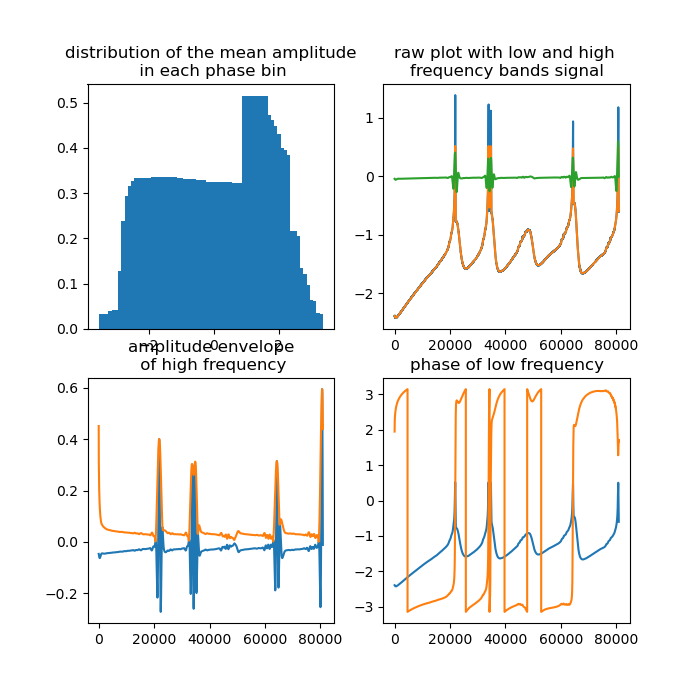

Modulation Index = 0.04791530174414832


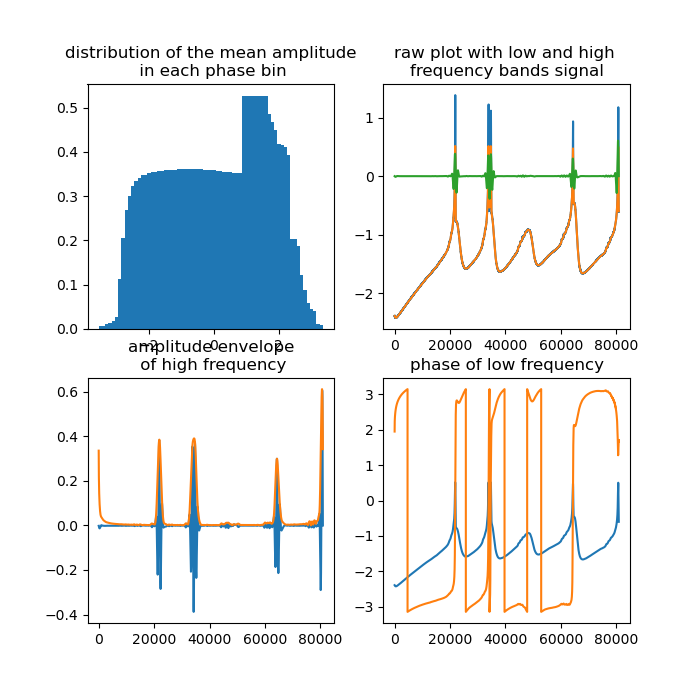

Modulation Index = 0.04899552681100013


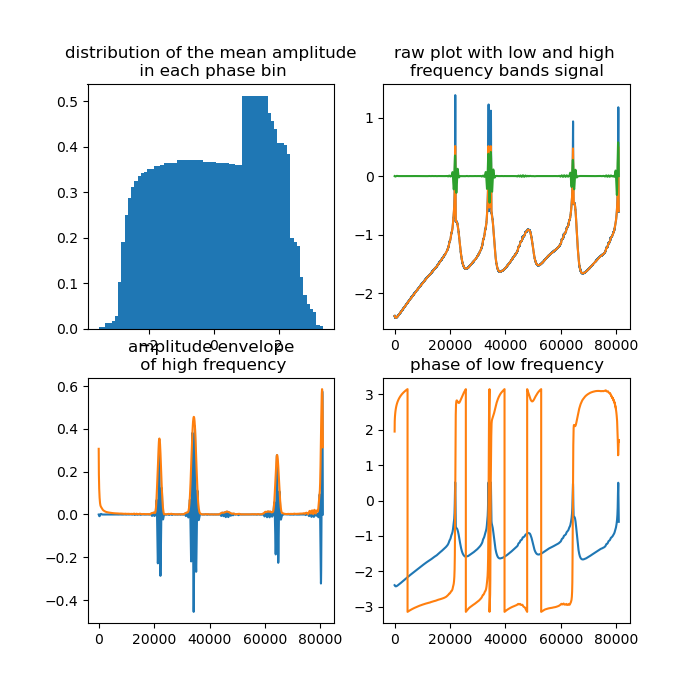

Modulation Index = 0.03725113331835238


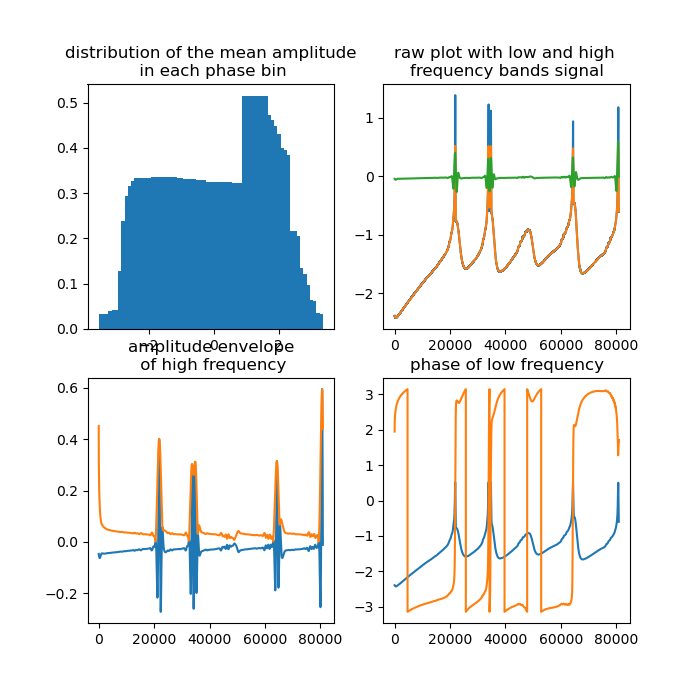

Modulation Index = 0.04791530174414832


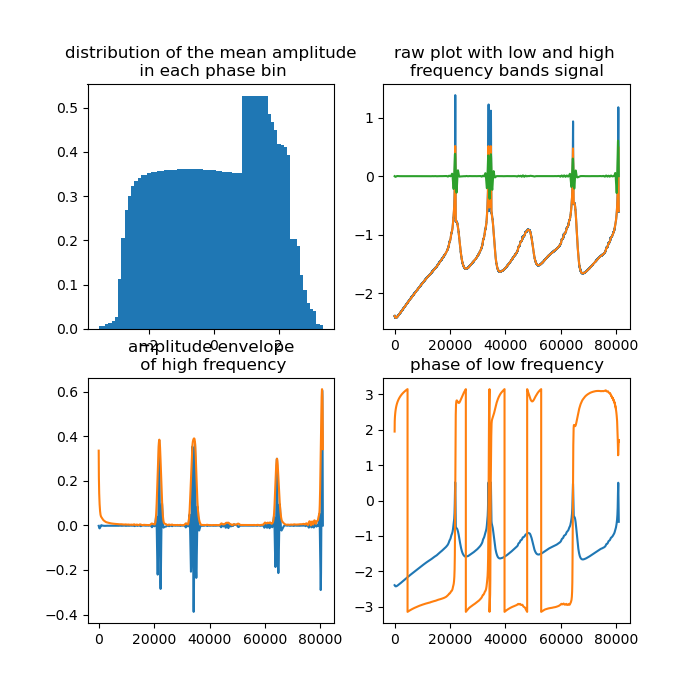

Modulation Index = 0.04899552681100013


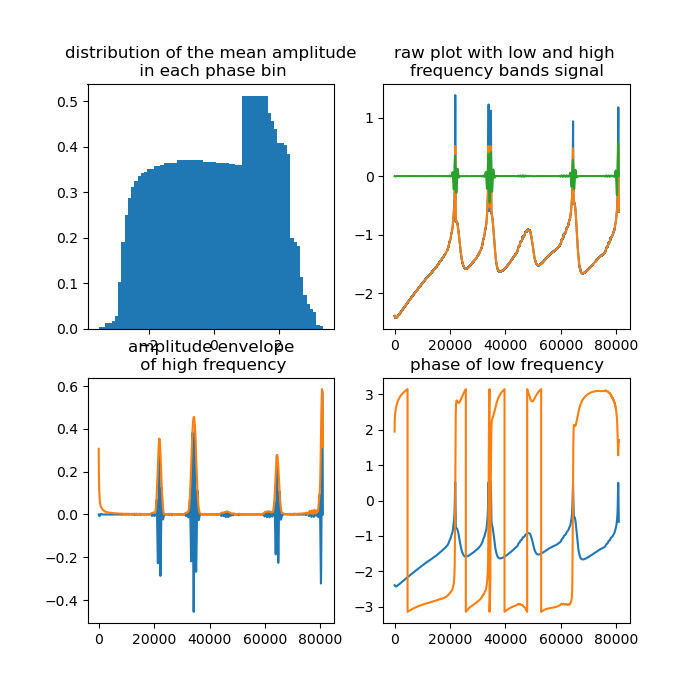

Modulation Index = 0.03725113331835238


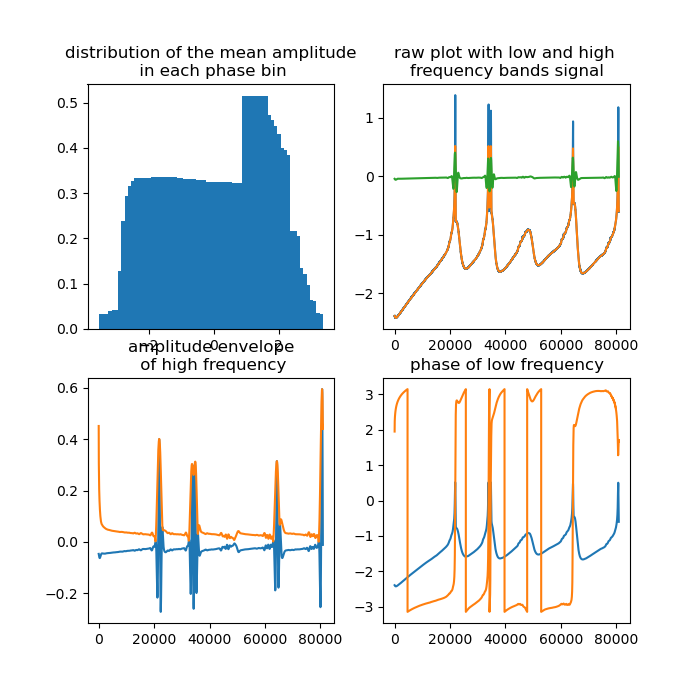

Modulation Index = 0.04791530174414832


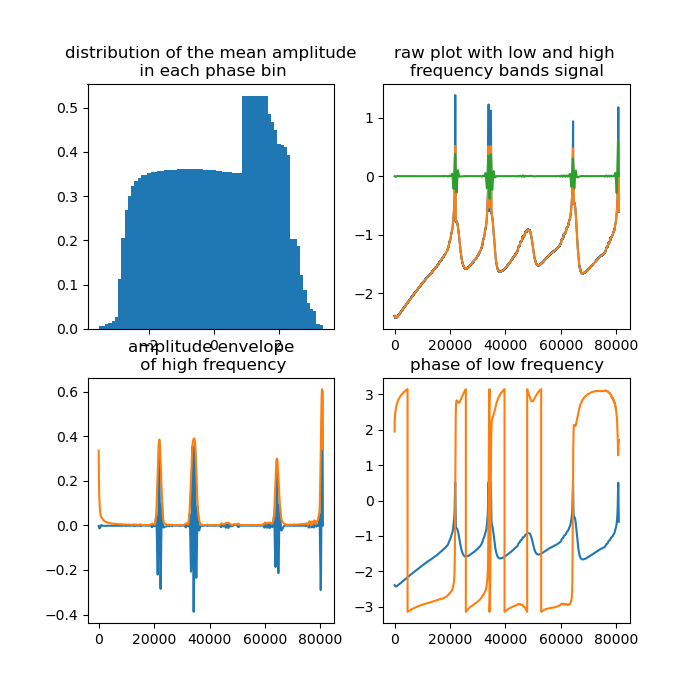

Modulation Index = 0.04899552681100013


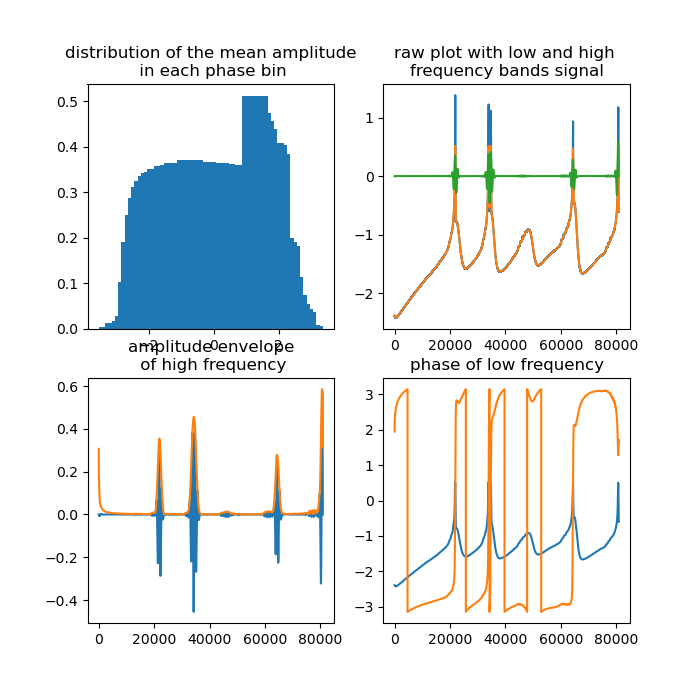

Modulation Index = 0.03725113331835238


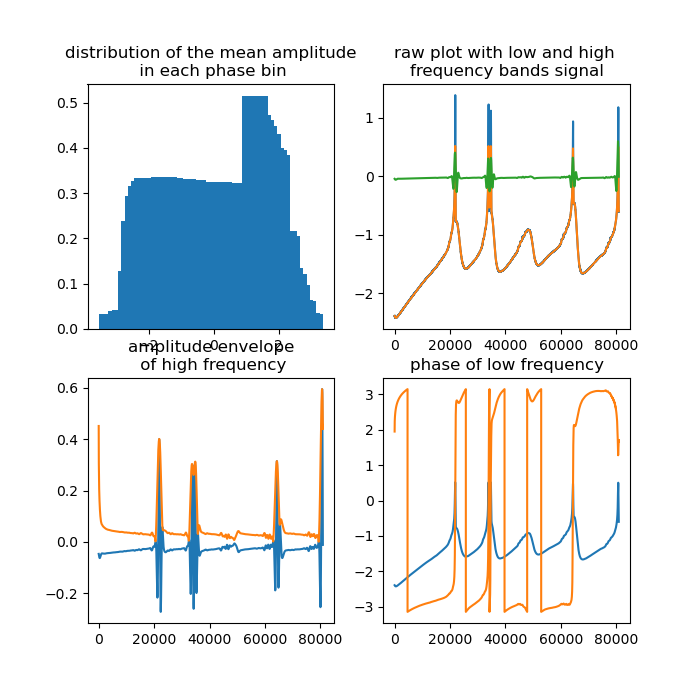

Modulation Index = 0.04791530174414832


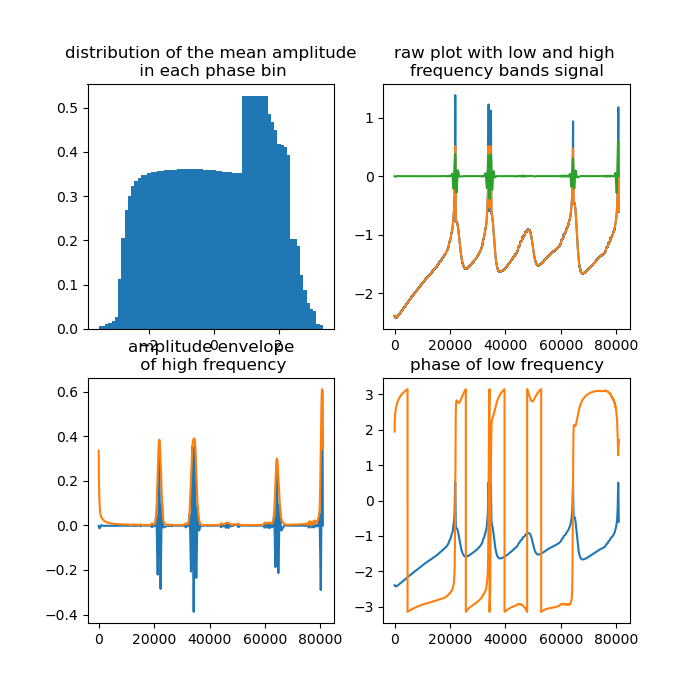

Modulation Index = 0.04899552681100013


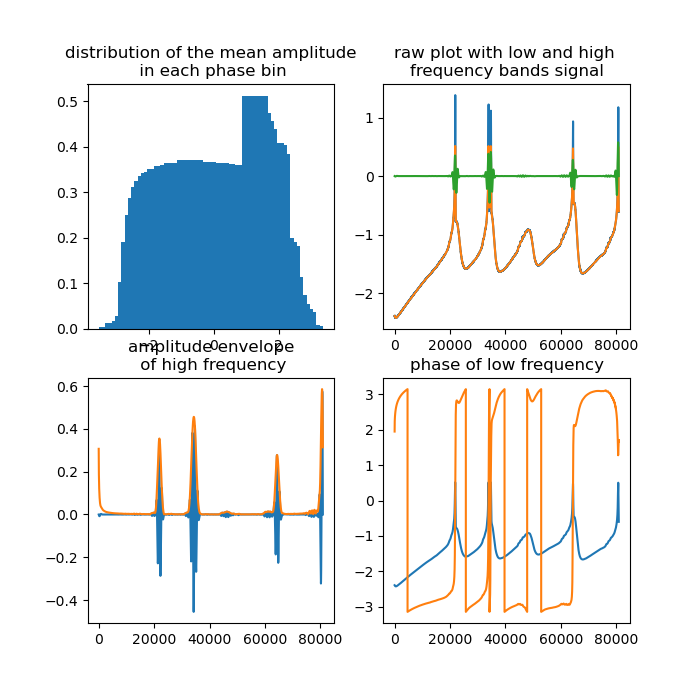

Modulation Index = 0.0372511699143813


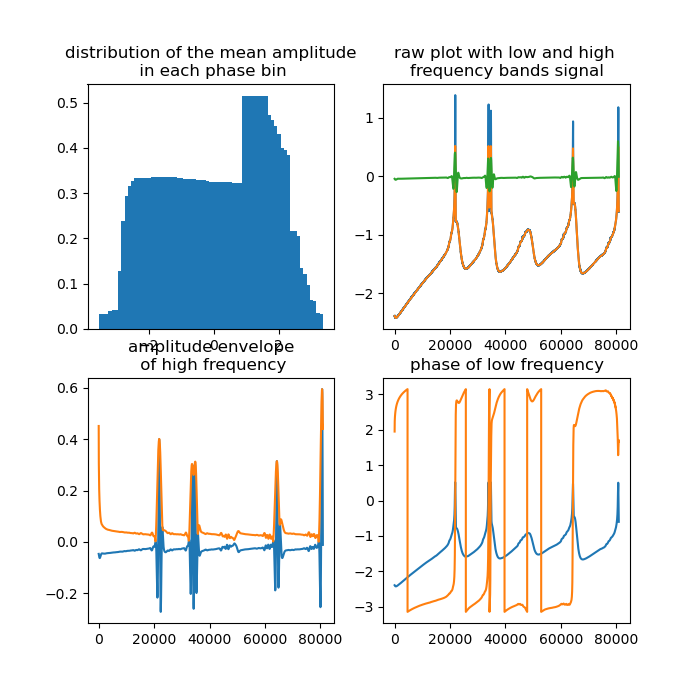

Modulation Index = 0.04791541671635773


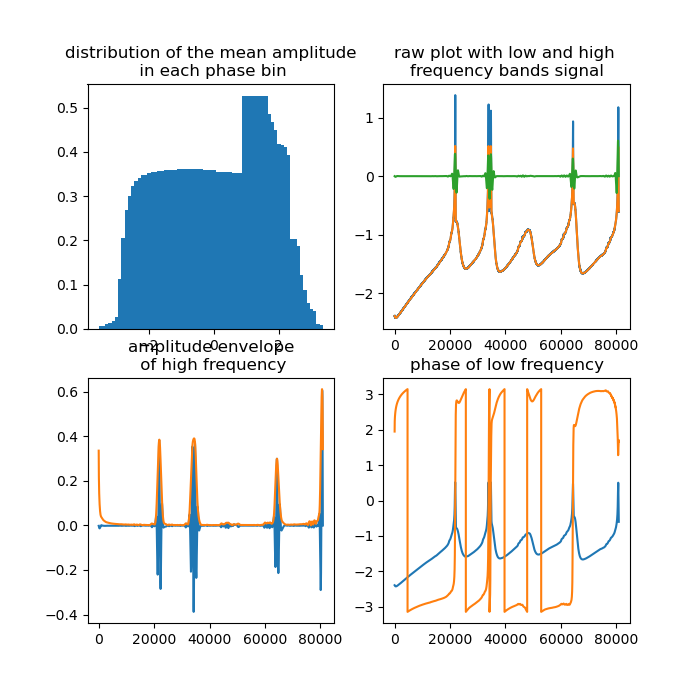

Modulation Index = 0.04899628196521501


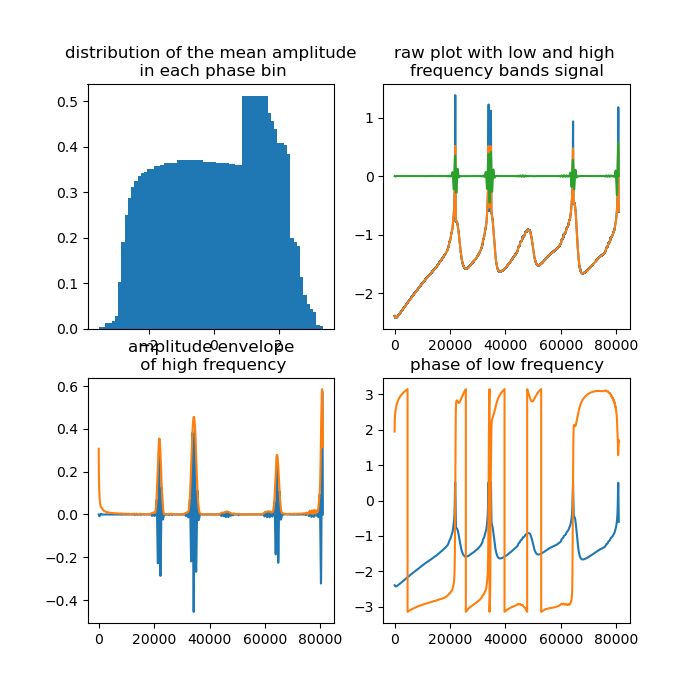

Modulation Index = 0.0372506930040793


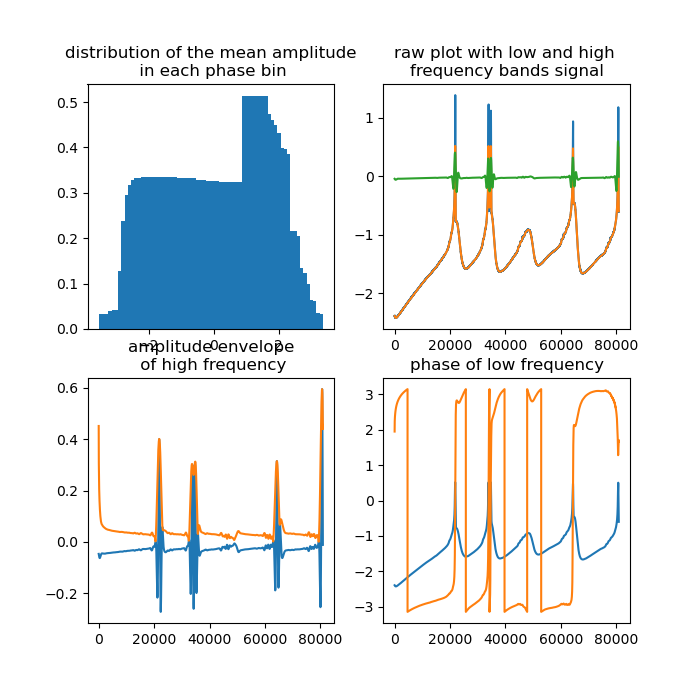

Modulation Index = 0.04791456870667375


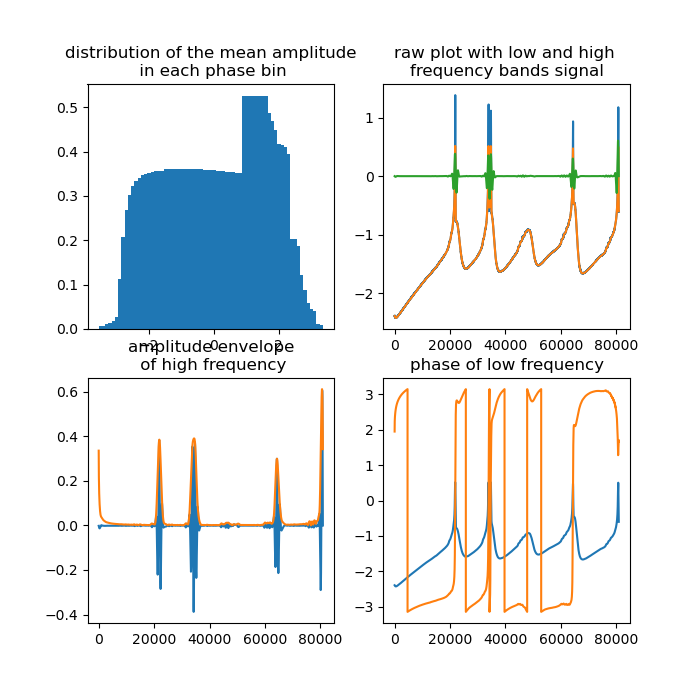

Modulation Index = 0.04899538914909095


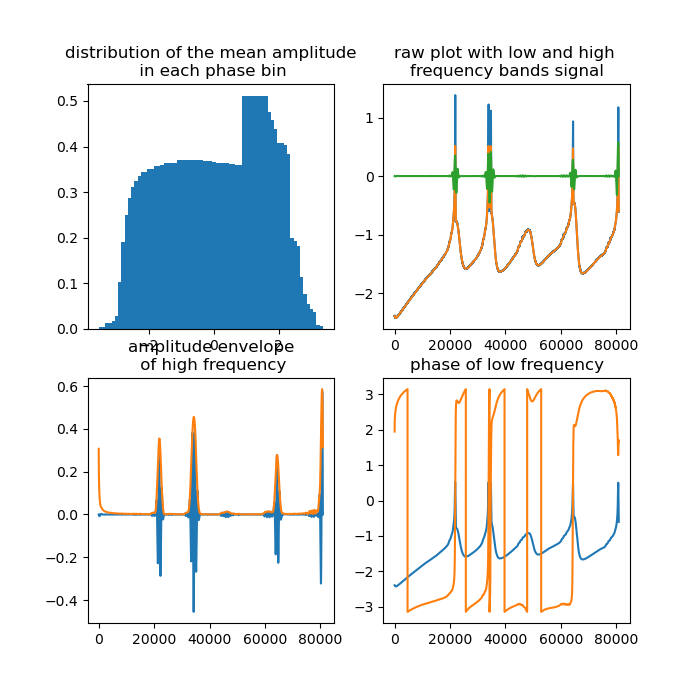

Modulation Index = 0.03725067953707182


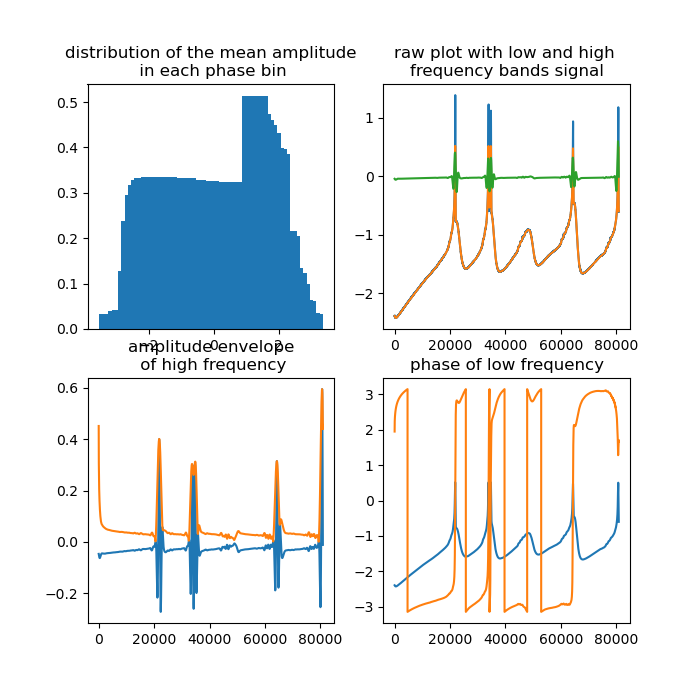

Modulation Index = 0.04791444750118489


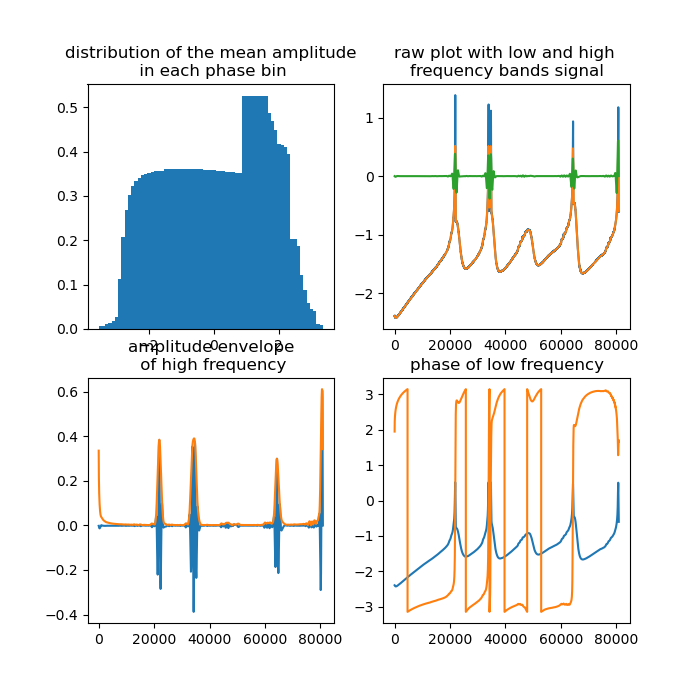

Modulation Index = 0.048994753088796056


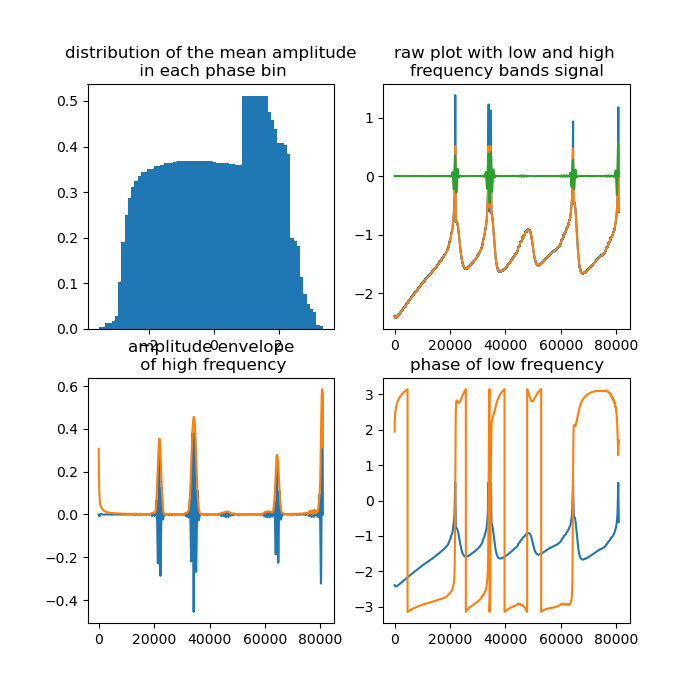

In [29]:
def PAC_comodulogram(data, low_paras, high_paras, fs, n_order_low = 256, n_order_high=2048, visual=False):
    data = np.array(data)
    phase_x = np.arange(*low_paras)
    amplitude_y = np.arange(*high_paras)
    como_df = pd.DataFrame(index=phase_x[:-1], columns=amplitude_y[:-1])
    for xi, i in enumerate(phase_x[:-1]):
        for yi, j in enumerate(amplitude_y[:-1]):
            mi = PAC(data, [i, phase_x[xi+1]], [j, amplitude_y[yi+1]], fs=fs, visual=visual)
            como_df.iloc[xi,yi] = mi
            como_df[como_df.columns[yi]] = como_df[como_df.columns[yi]].astype(float, errors = 'raise')
    sns.headmap(como_df)
    plt.show()

PAC_comodulogram(df_left, [2,10,1],[60, 100, 10], fs=81920, n_order_low=64)